In [1]:
import random
import time
import os
import sys
# Automatically find and add the project root directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from tsai.all import *
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import *
from torch.utils.data.dataset import ConcatDataset
from tsai.utils import set_seed
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
# from aeon.datasets import load_classification
# from sktime.datasets import load_UCR_UEA_dataset
from lomatce.explainer import LomatceExplainer
import lomatce.perturbation as perturbation 
import lomatce.utils.test_dataloader as test_loader




set_seed(1024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"device: {device}")
my_setup()

device: cuda
os              : Windows-10-10.0.26100-SP0
python          : 3.11.13
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.2+cu118
device          : 1 gpu (['NVIDIA GeForce RTX 4050 Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.68 GB
GPU memory      : [6.0] GB


In [2]:
# Set a random seed to ensure that the results are reproducible
random_seed = 45

torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
# List of univariate datasets from UCR archive
print(get_UCR_univariate_list())

# List of multivariate datasets from UCR archieve
print(get_UCR_multivariate_list())

['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'I

In [4]:
dsid = 'GunPoint'
dataset_name = dsid.lower()
model = 'FCN'.lower()

cur_time = time.strftime('%Y-%m-%d_%H-%M-%S')
if 'cuda' in str(device):
    base_dir = f'results/{dataset_name}/{model}--{cur_time}' 
else:
    base_dir = f'results/ecg200--2023-12-28_16-37-54' 
#Create the base directory if not exist
os.makedirs(base_dir, exist_ok=True)

In [5]:
X, y, splits  = get_UCR_data(dsid, on_disk=True, return_split=False)

In [6]:
unique_classes, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} instances")

Class 1: 100 instances
Class 2: 100 instances


### Load and preprocess data

In [7]:
def data_preparation(X, y, test_size=0.3, random_state=12):
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    #Reserve 10% for validation, validation set is required in fastai
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=random_state)

    print(f'Shape of X_train :{X_train.shape}')
    print(f'Shape of y_train :{y_train.shape}')
    print(f'Shape of X_valid :{X_valid.shape}')
    print(f'Shape of X_test :{X_test.shape}')

    tfms  = [None, [Categorize()]]
    train_ds = TSDatasets(X_train, y_train, tfms=tfms)
    # valid_ds = TSDatasets(X_valid, y_valid, tfms=tfms)
    valid_ds = TSDatasets(X_valid, y_valid, tfms=tfms)

    dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=[8, 32], batch_tfms=[TSStandardize()], num_workers=0,  device=device, shuffle=True )
    print(f' Number of classes : {dls.c}')
    return dls, X_train, X_test, y_test

In [9]:
lomatce_explainer = LomatceExplainer(base_dir=base_dir)
dls, X_train, X_test, y_test = data_preparation(X, y) # X_train is only used for SHAP method

Shape of X_train :(140, 1, 150)
Shape of y_train :(140,)
Shape of X_valid :(30, 1, 150)
Shape of X_test :(30, 1, 150)
 Number of classes : 2


### Build learner and train model

In [10]:
def trainer (model, dls, epochs=100, learning_rate=1e-3, patience=15):
    kwargs = {}
    metrics=[accuracy]
    path = f'{base_dir}/export'
    os.makedirs(path, exist_ok=True)
    # Create model
    model = create_model(model, dls=dls, **kwargs)
    # Define early stopping criteria
    early_stopping = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=patience)

    # Define a call back to save the best model
    save_callback = SaveModelCallback(monitor='accuracy')
    # Train and evaluate model with early stopping
    # set_seed(42)
    cbs = [early_stopping, save_callback,ShowGraph()]
    learn = Learner(dls=dls, model=model, opt_func=Adam, metrics=metrics,cbs=cbs) #
    learn.fit_one_cycle(epochs, learning_rate)
    learn.save_all(path=path, dls_fname='dls', model_fname='model', learner_fname='learner')
    return learn

def validator(learn, X_test, y_test):
    dls = learn.dls
    valid_dl = dls.valid
    train_dl = dls.train
    # Labelled test data
    test_ds = valid_dl.dataset.add_test(X_test, y_test)# In this case I'll use X and y, but this would be your test data
    test_dl = valid_dl.new(test_ds)
    test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    # print(f'Test Accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    train_probas, train_targets, train_preds = learn.get_preds(dl=train_dl, with_decoded=True)
    
    valid_accuracy = (valid_targets == valid_preds).float().mean()
    test_accuracy = (test_targets == test_preds).float().mean()
    train_accuracy = (train_targets == train_preds).float().mean()

    print(f"Validation Accuracy :{valid_accuracy:.2f}")
    print(f"Test Accuracy :{test_accuracy:.2f}")
    print(f"Train Accuracy :{train_accuracy:.2f}")
    valid_dl.show_batch(sharey=True)
    test_dl.show_batch(sharey=True)
    learn.show_results(max_n=9)

    return train_accuracy, valid_accuracy, test_accuracy, test_preds, valid_preds

Shape of X_train :(140, 1, 150)
Shape of y_train :(140,)
Shape of X_valid :(30, 1, 150)
Shape of X_test :(30, 1, 150)
 Number of classes : 2
Start training...


epoch,train_loss,valid_loss,accuracy,time
0,0.711974,0.690731,0.500000,00:01
1,0.688622,0.602374,0.800000,00:00
2,0.664429,0.559482,0.800000,00:00
3,0.645344,0.517265,0.833333,00:00
4,0.629685,0.484571,0.900000,00:00
5,0.610453,0.475909,0.900000,00:00
6,0.591627,0.425873,0.933333,00:00
7,0.571878,0.410260,0.900000,00:00
8,0.546439,0.394847,0.966667,00:00
9,0.519762,0.385972,0.966667,00:00


Better model found at epoch 0 with accuracy value: 0.5.


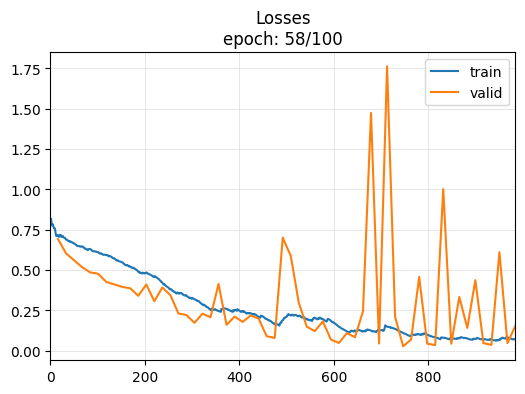

Better model found at epoch 1 with accuracy value: 0.8000000715255737.
Better model found at epoch 3 with accuracy value: 0.8333333730697632.
Better model found at epoch 4 with accuracy value: 0.9000000357627869.
Better model found at epoch 6 with accuracy value: 0.9333333969116211.
Better model found at epoch 8 with accuracy value: 0.9666666388511658.
Better model found at epoch 17 with accuracy value: 1.0.
No improvement since epoch 43: early stopping


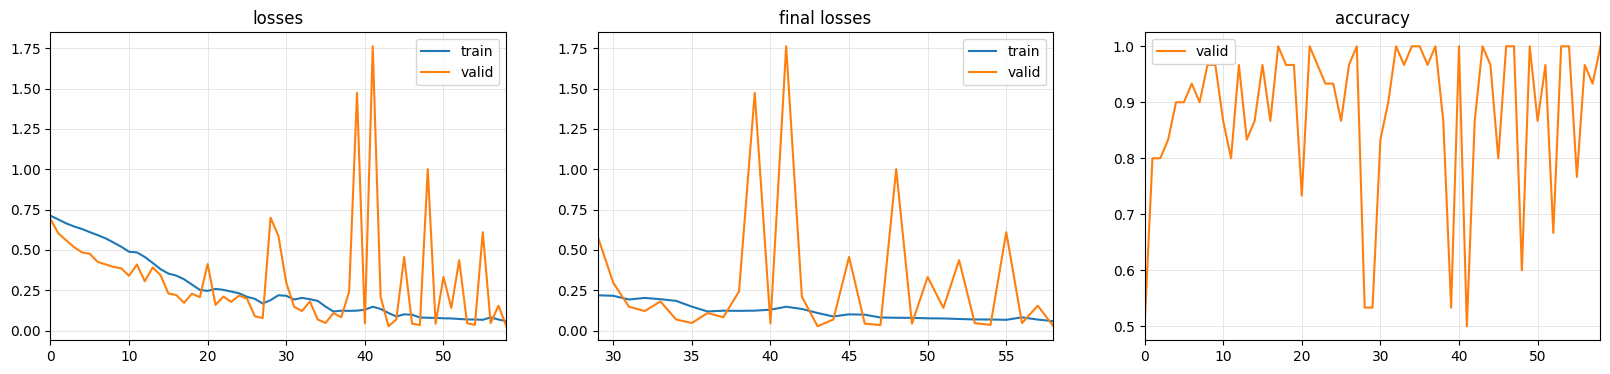

cuda


In [11]:
dls, X_train, X_test, y_test= data_preparation(X, y)
# Run the trainer function only if CUDA is available
if 'cuda' in str(device):
    print('Start training...')
    learn_new = trainer(FCN, dls)
# else:
#     learn_new = load_learner_all(path=f'{base_dir}/export/',
#                                dls_fname='dls', model_fname='model', learner_fname='learner')
    # train_acc, valid_acc, test_acc, test_preds, valid_preds = validator(learn_new, X_test, y_test)
print(device)

Validation Accuracy :1.00
Test Accuracy :1.00
Train Accuracy :1.00


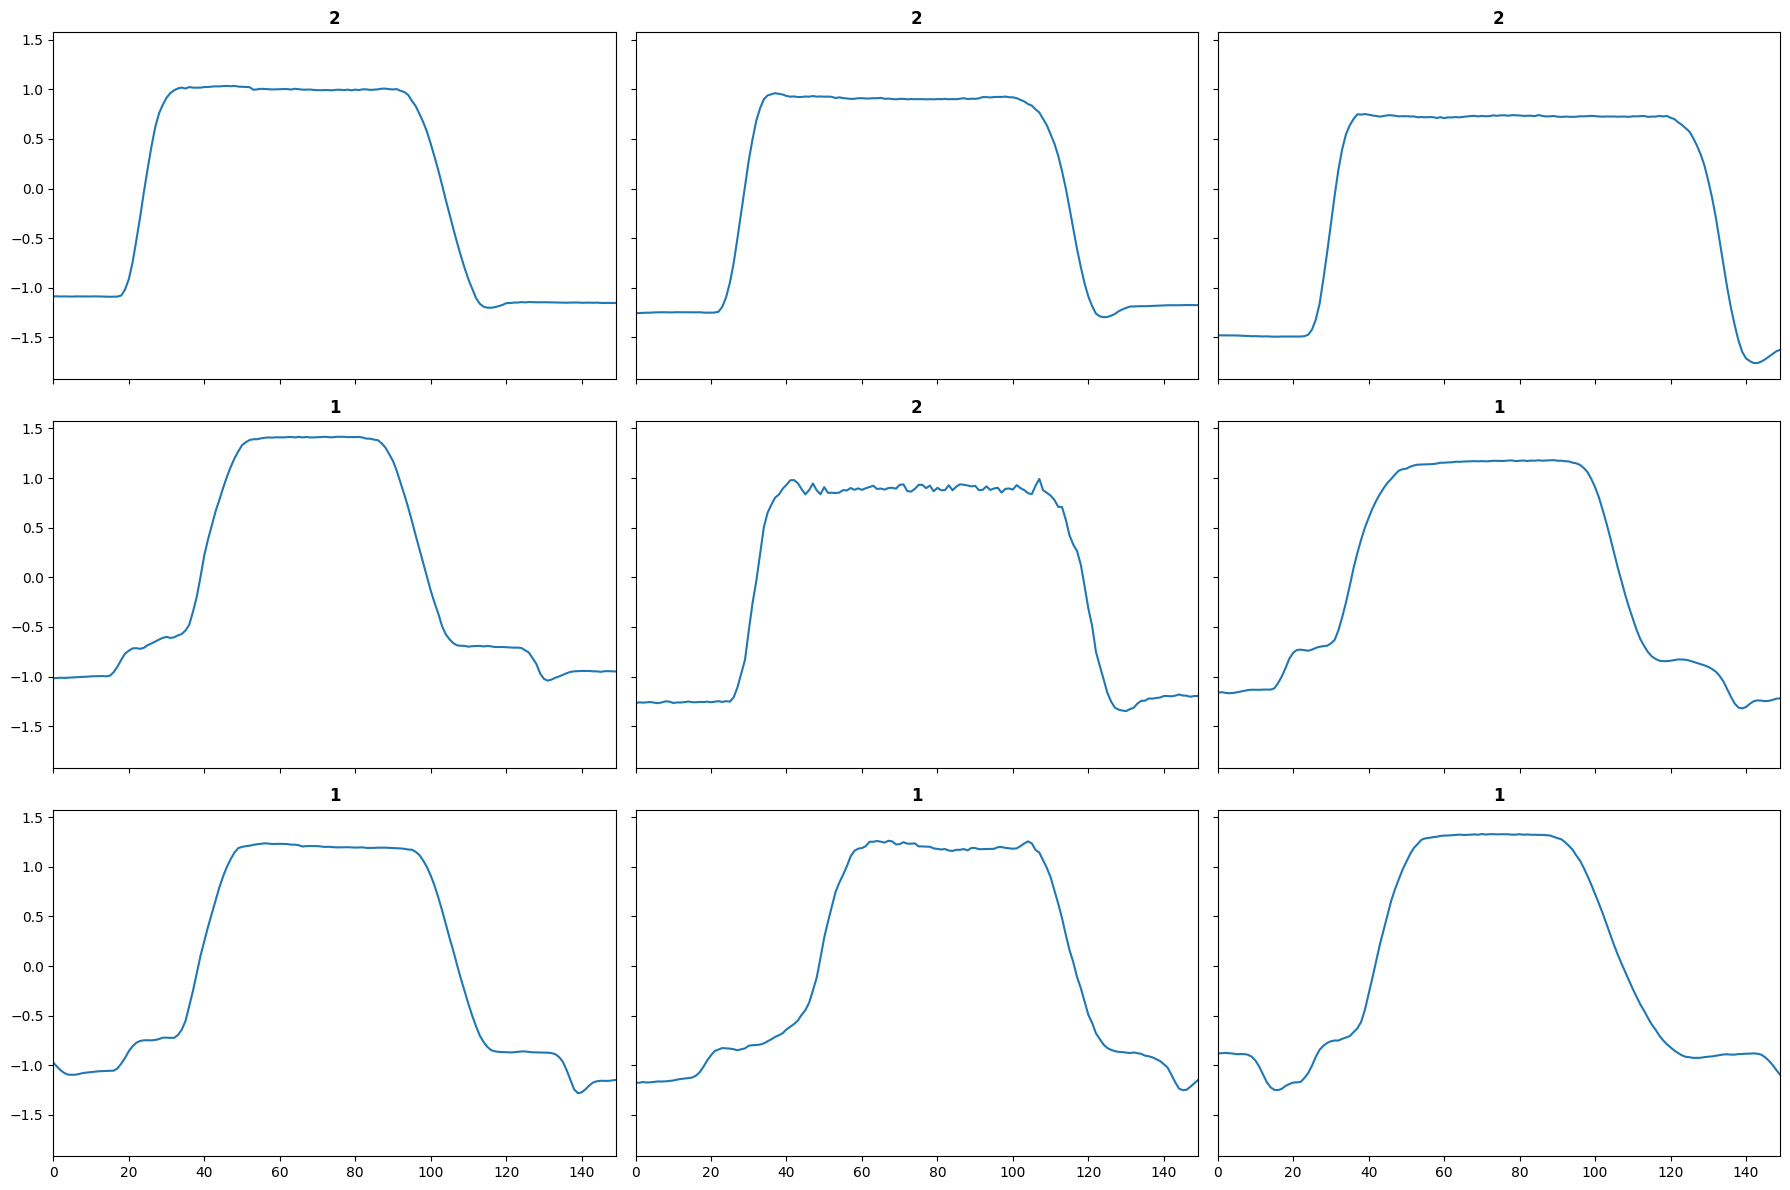

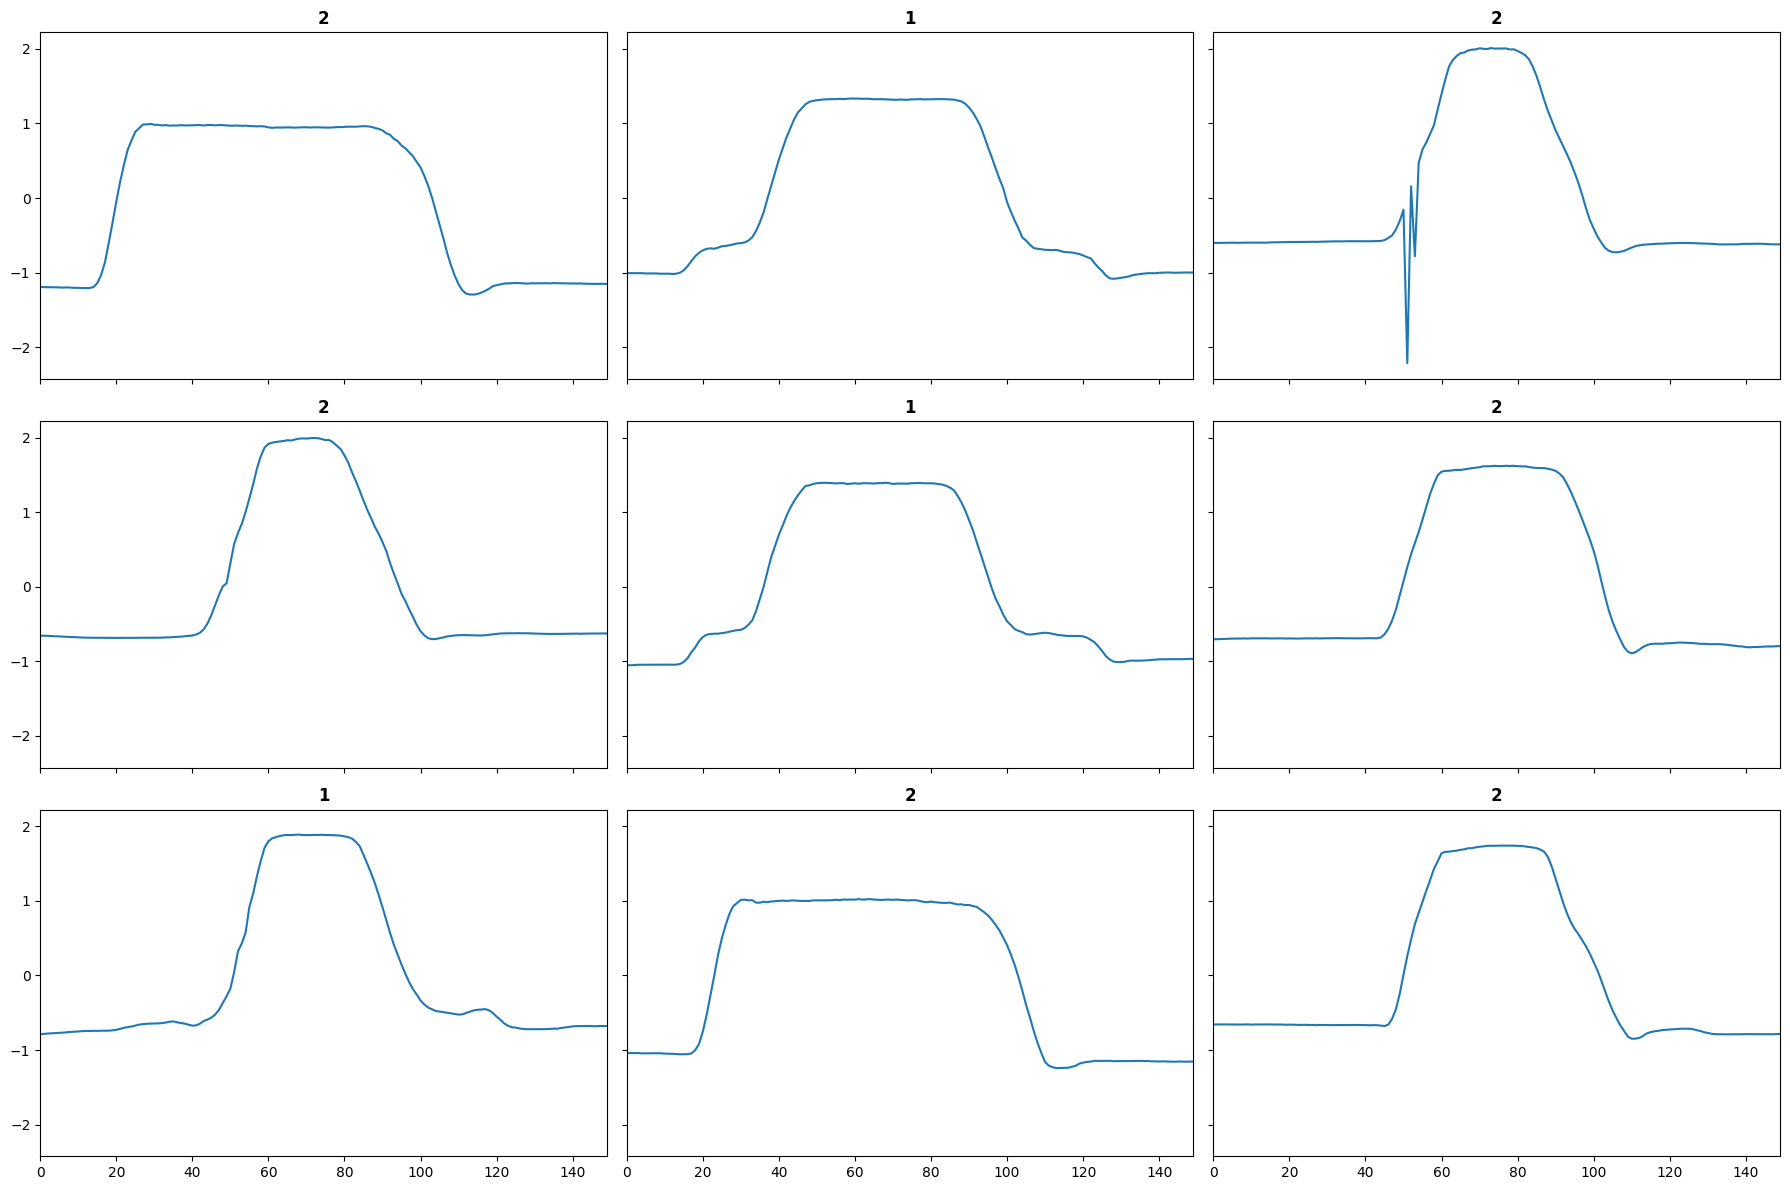

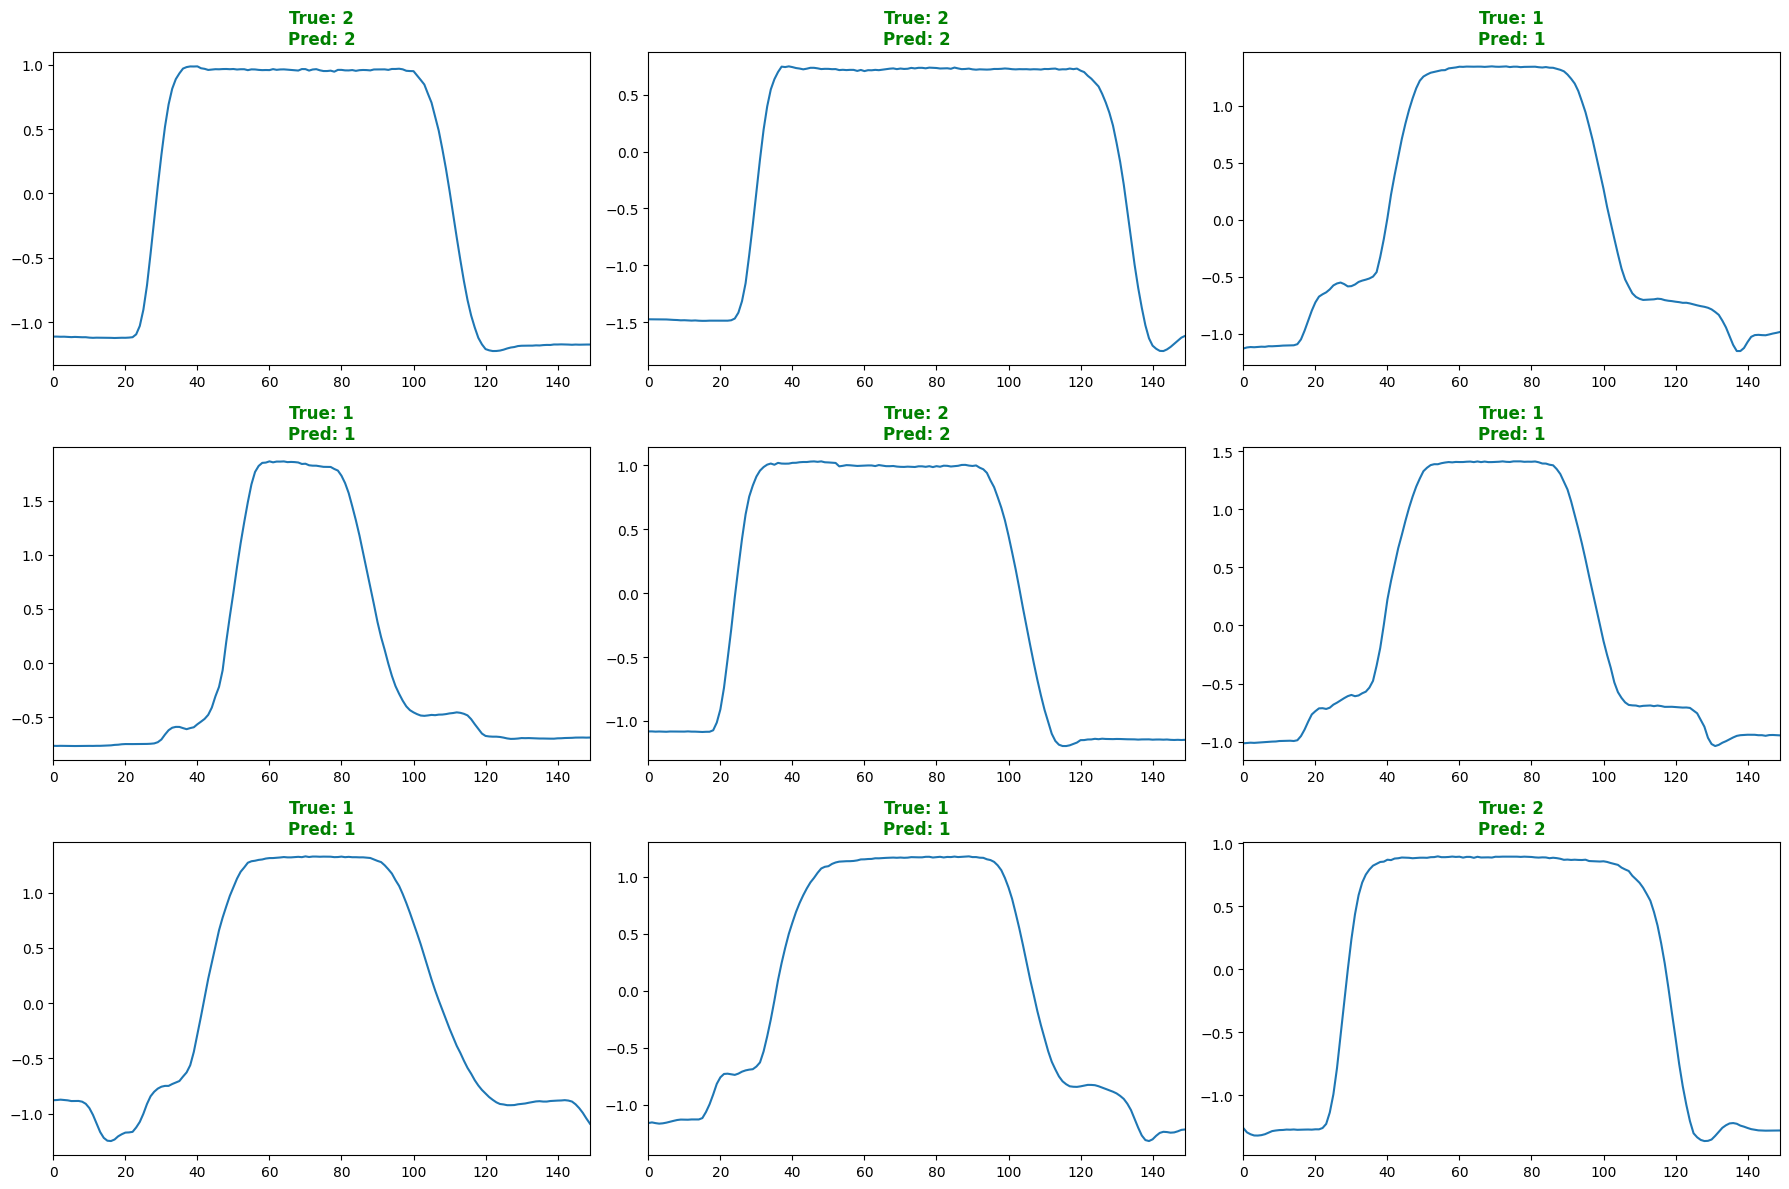

In [12]:
train_acc, valid_acc, test_acc, test_preds, valid_preds = validator(learn_new, X_test, y_test)

In [12]:
learn_new.summary()

not enough values to plot a chart


FCN (Input shape: 8 x 1 x 150)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 128 x 150       
Conv1d                                    896        True      
BatchNorm1d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 256 x 150       
Conv1d                                    163840     True      
BatchNorm1d                               512        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 150       
Conv1d                                    98304      True      
BatchNorm1d                               256        True      
ReLU                                                           
_________________________________________________

In [13]:
class_labels = ['Gun','No Gun']

In [14]:
test_preds

tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [14]:
def predict_fn(data, learner):
    if len(data.shape) == 2:
        data = data.reshape(data.shape[0], 1, data.shape[1])
    data_dl = test_loader.test_dataloader(learner, data)
    data_probas, _, data_preds = learner.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas, data_preds

### Apply LOMATCE (Local Model-Agnostic TimeSeries Classifers Explanation)
LOMATCE is a novel Explainable AI (XAI) method designed specifically for time series classifiers. It generates explanations that preserve the temporal characteristics of time series data.

INFO:lomatce.explainer:Starting time series local explanation
INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 13 = 13
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Parallel execution failed: Unable to allocate 1.00 GiB for an array with shape (9086, 14771) and data type float64. Running sequentially.
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 68) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 68


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.7
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.82
INFO:lomatce.explainer:Model Type: Ridge


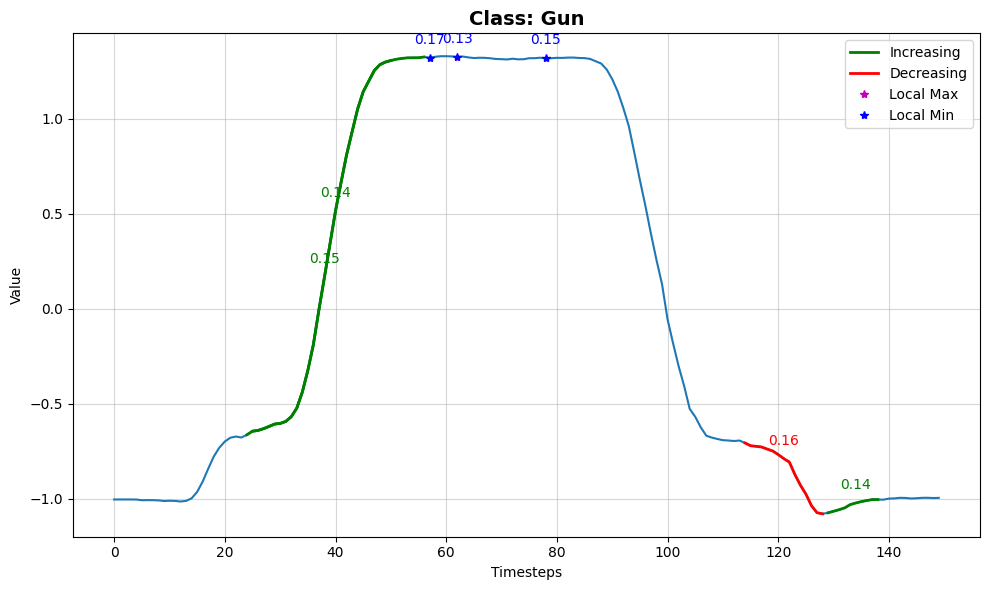

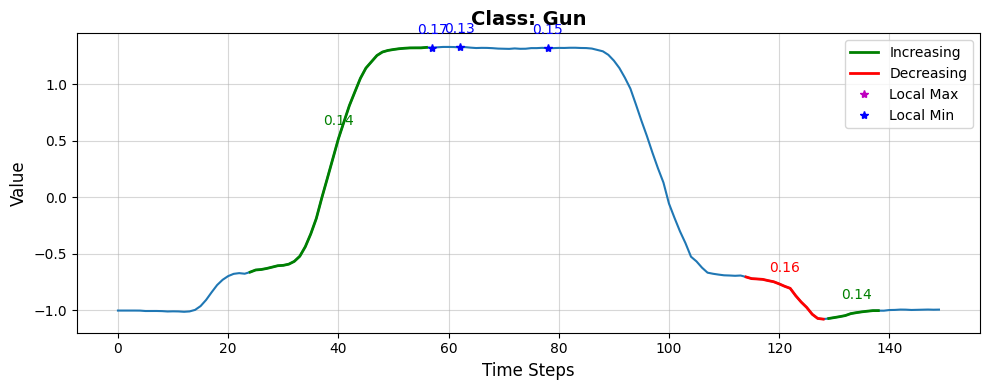

Predection probability : tensor([0.9002, 0.0998])
Gun:                      0.9002
No Gun:                      0.0998


In [16]:
origi_instance_0 = X_test[2] # Instance that is classified as Gun
explanation = lomatce_explainer.explain_instance(origi_instance_0, lambda data: predict_fn(data, learn_new), num_perturbations=1000, class_names=class_labels, replacement_method='zero')

INFO:lomatce.explainer:Starting time series local explanation


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 3 = 3
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 3 = 3


INFO:lomatce.explainer:Final data shape: (1001, 44) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 44


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.62
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.92
INFO:lomatce.explainer:Model Type: Ridge


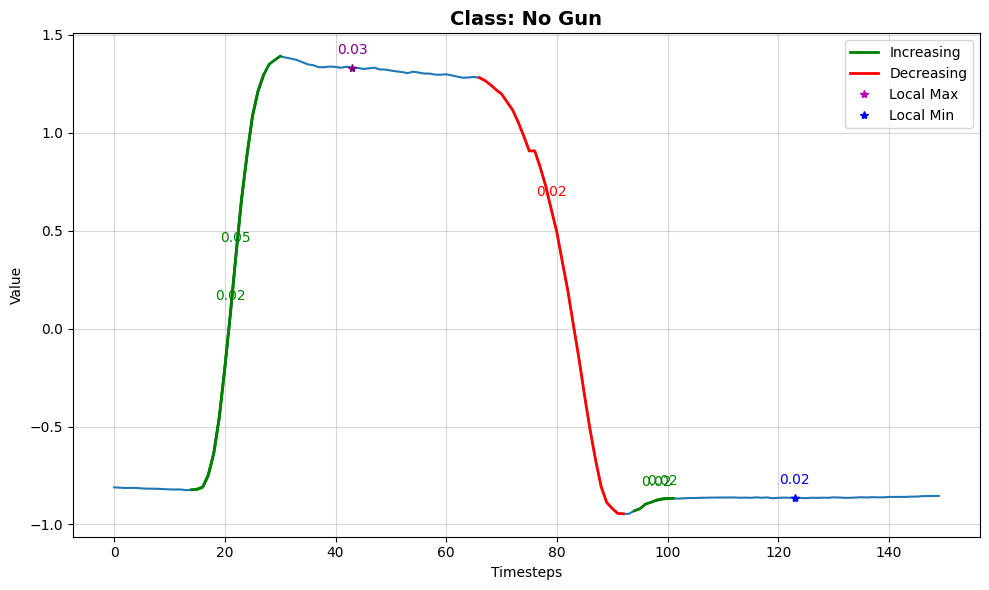

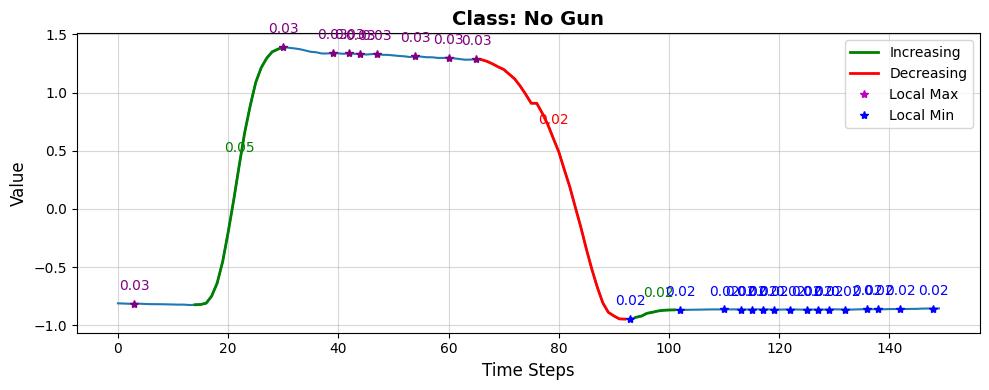

Predection probability : tensor([0.1697, 0.8303])
Gun:                      0.1697
No Gun:                      0.8303


In [17]:
origi_instance_1 = X_test[1] # Instance that is classified as No Gun
explanation = lomatce_explainer.explain_instance(origi_instance_1, lambda data : predict_fn(data, learn_new), num_perturbations=1000, top_n=15, class_names=class_labels, replacement_method='total_mean')

INFO:lomatce.explainer:Starting time series local explanation


Replacement methods: zero


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Parallel execution failed: Unable to allocate 1.00 GiB for an array with shape (6059, 22149) and data type float64. Running sequentially.
Optimal number of clusters for LocalMax_ch1: 3 = 3
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 3 = 3


INFO:lomatce.explainer:Final data shape: (1001, 43) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 43


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.62
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.75
INFO:lomatce.explainer:Model Type: Ridge


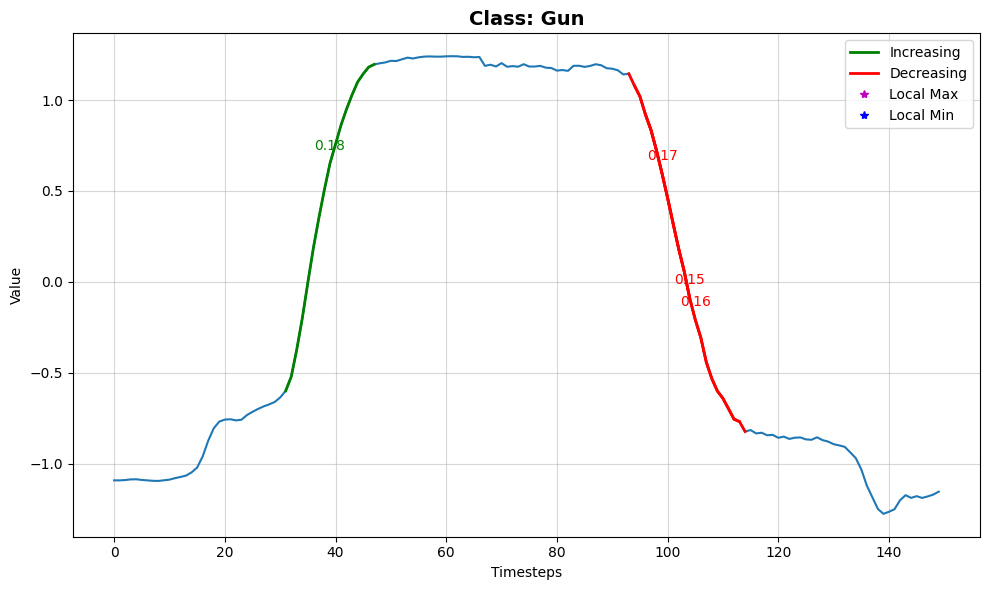

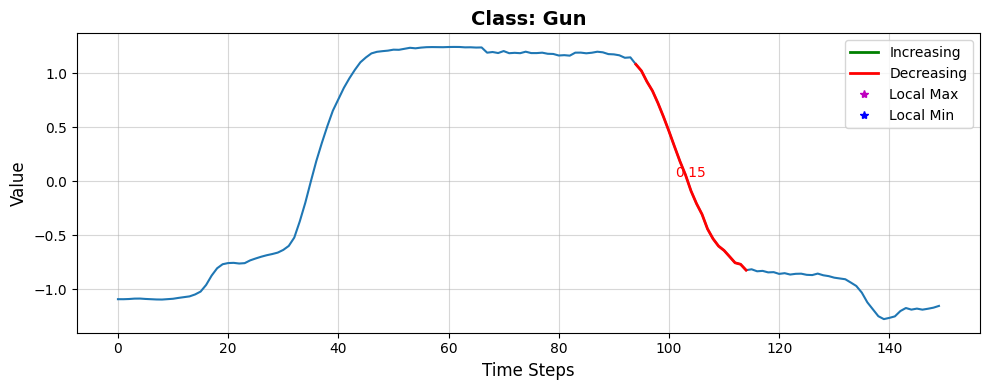

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8920, 0.1080])
Gun:                      0.8920
No Gun:                      0.1080


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Parallel execution failed: Unable to allocate 1.00 GiB for an array with shape (10022, 13392) and data type float64. Running sequentially.
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.9
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.77
INFO:lomatce.explainer:Model Type: Ridge


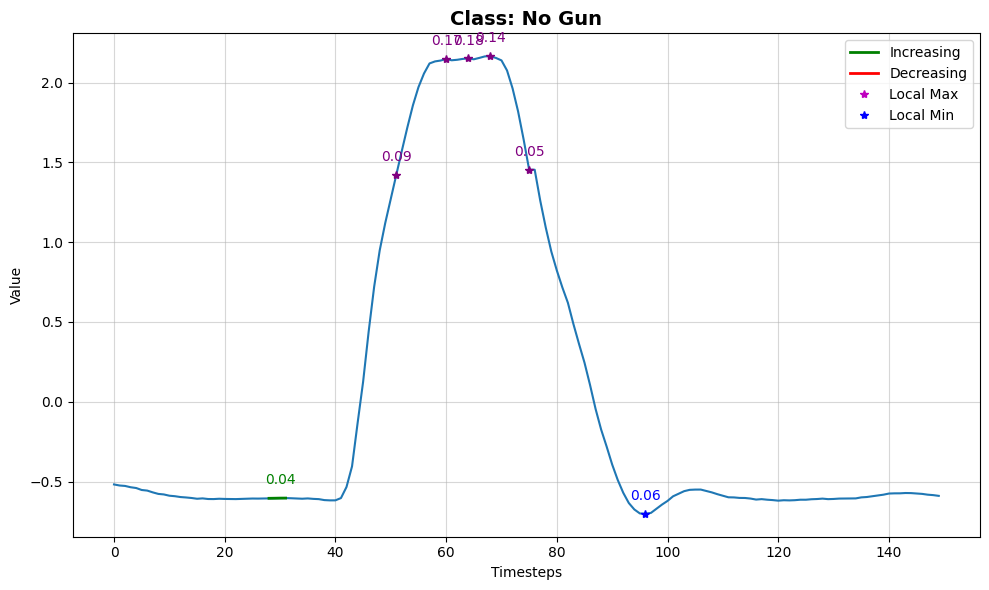

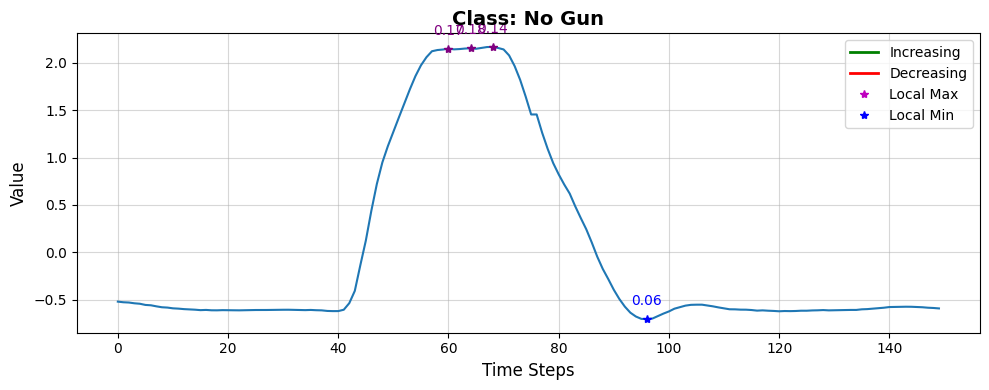

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.3015, 0.6985])
Gun:                      0.3015
No Gun:                      0.6985


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 7 = 7
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 3 = 3
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 46) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 46


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.81
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.77
INFO:lomatce.explainer:Model Type: Ridge


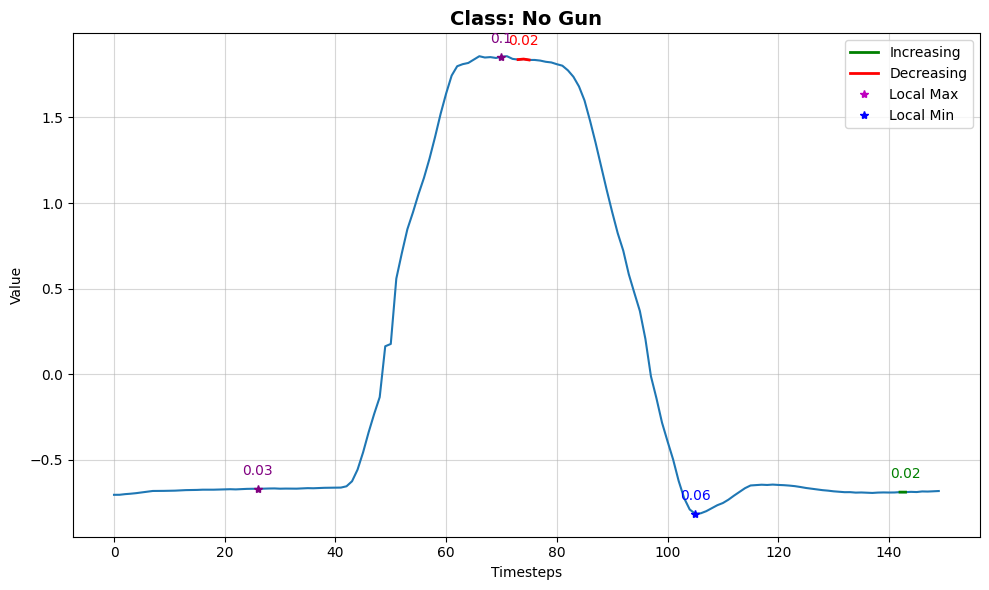

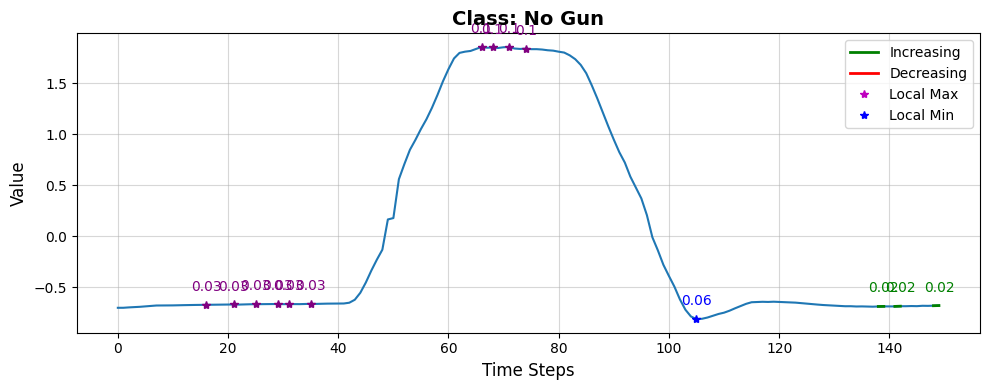

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.3551, 0.6449])
Gun:                      0.3551
No Gun:                      0.6449


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 3 = 3
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 58) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 58


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.71
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.74
INFO:lomatce.explainer:Model Type: Ridge


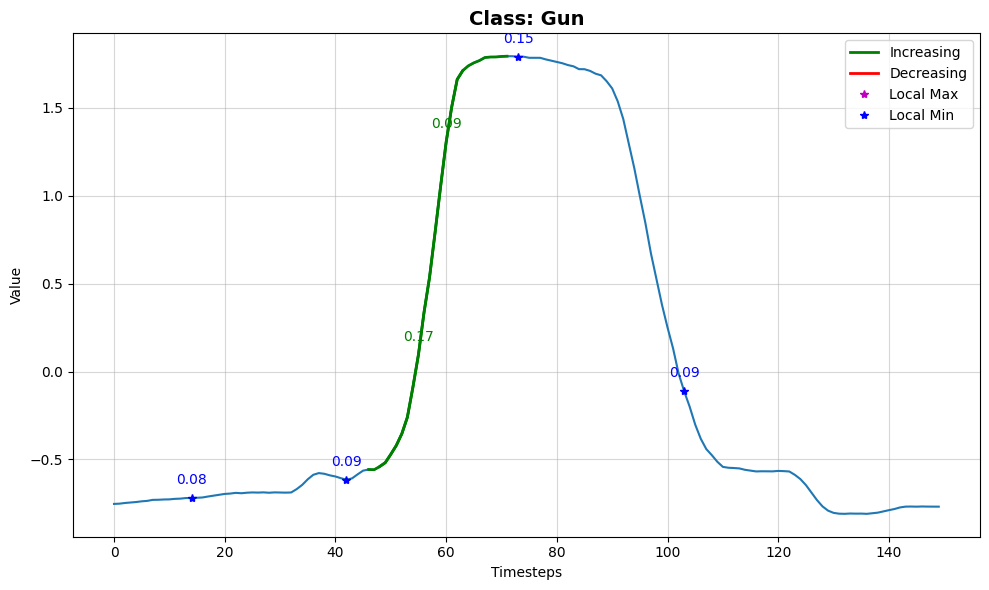

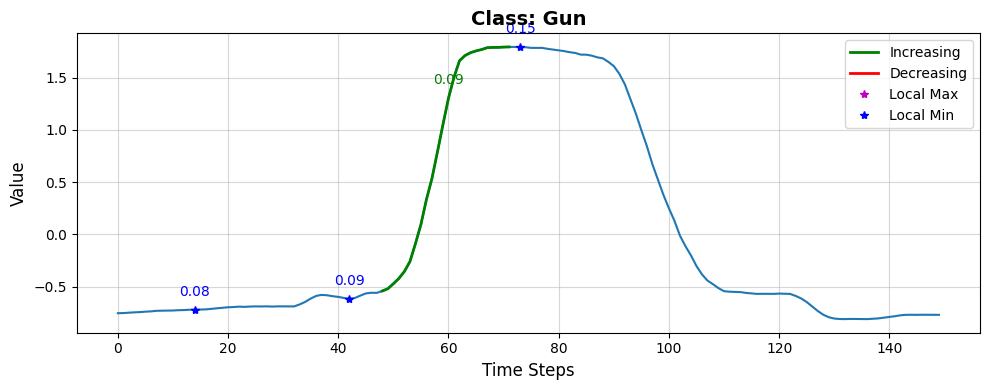

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8921, 0.1079])
Gun:                      0.8921
No Gun:                      0.1079


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 16 = 16
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 72) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 72


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.7
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.8
INFO:lomatce.explainer:Model Type: Ridge


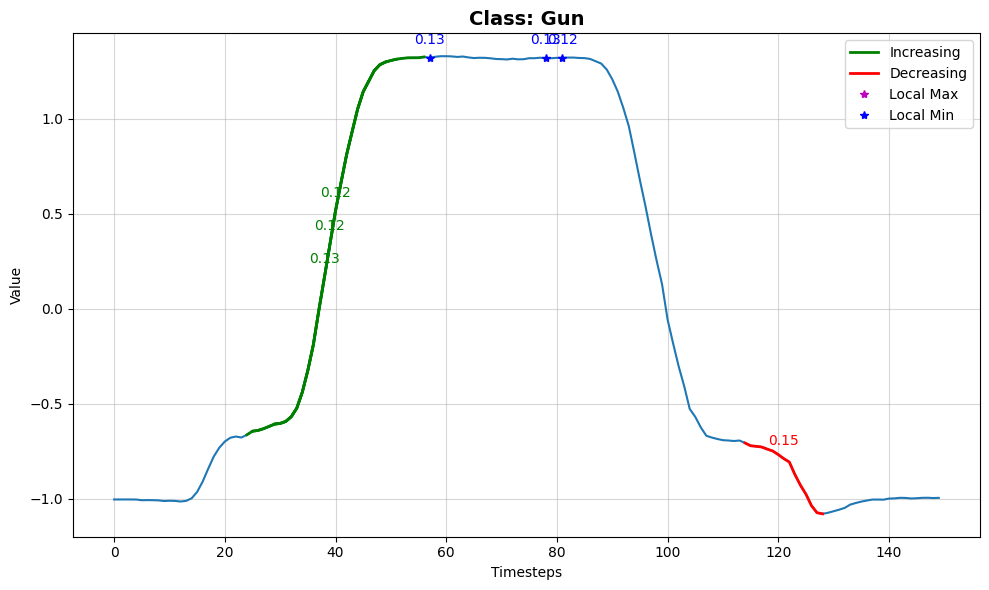

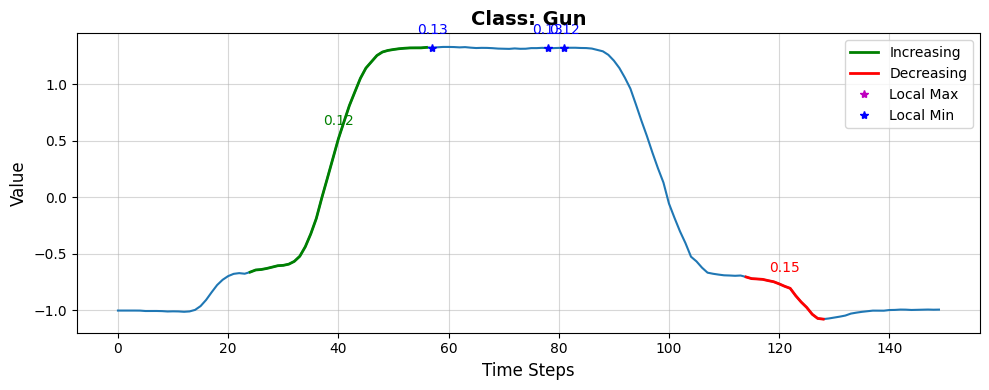

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.9002, 0.0998])
Gun:                      0.9002
No Gun:                      0.0998
Replacement methods: mean


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 15 = 15
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 71) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 71


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.73
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.9
INFO:lomatce.explainer:Model Type: Ridge


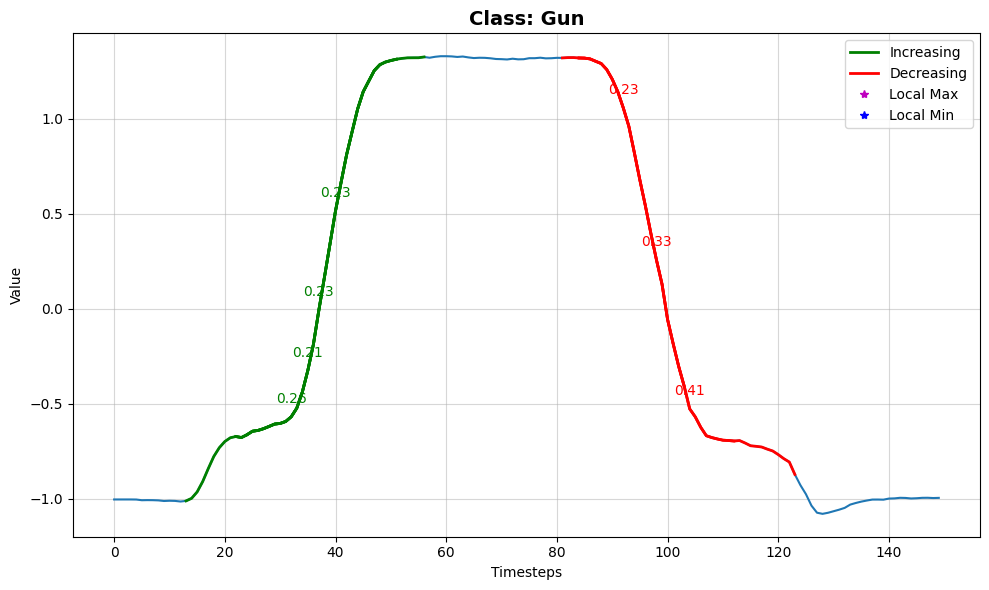

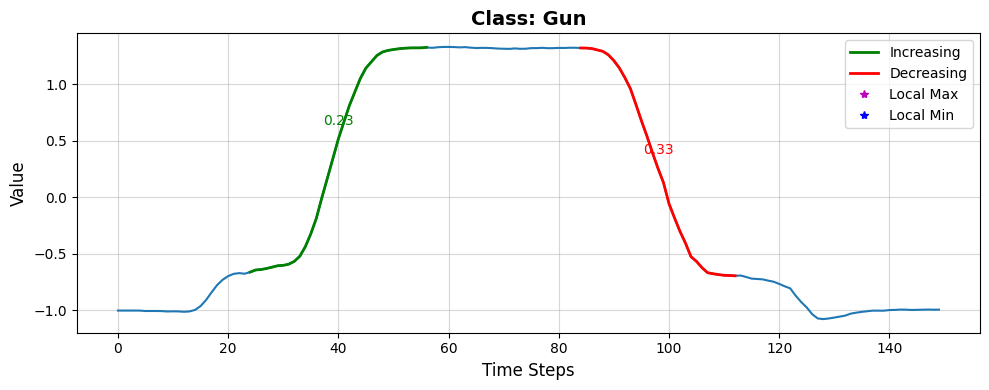

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.9002, 0.0998])
Gun:                      0.9002
No Gun:                      0.0998


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.71
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.59
INFO:lomatce.explainer:Model Type: Ridge


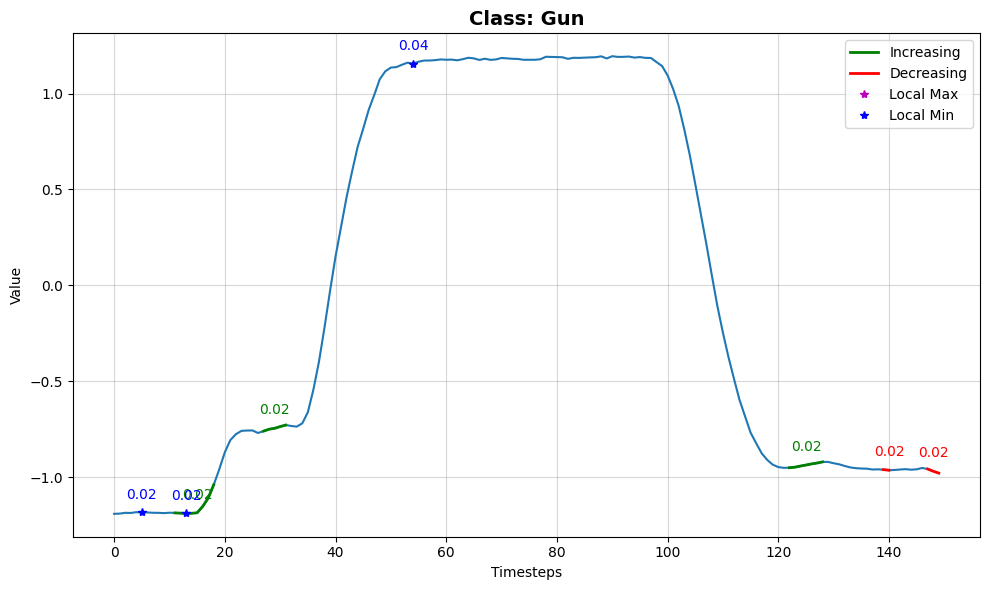

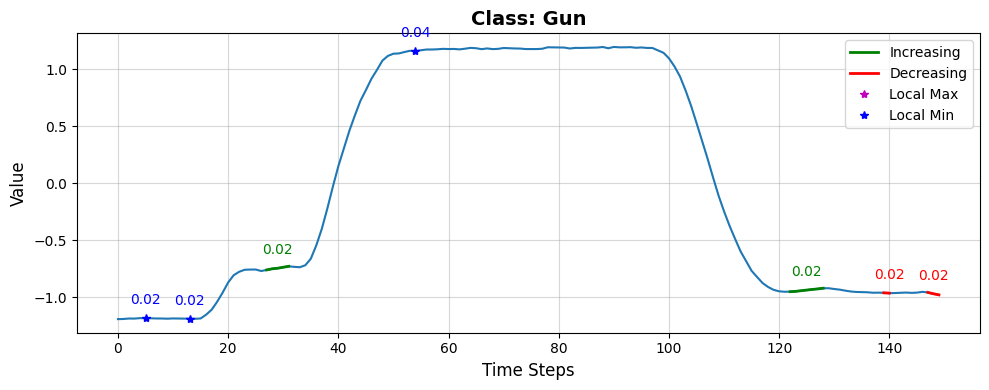

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.6113, 0.3887])
Gun:                      0.6113
No Gun:                      0.3887


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.77
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.82
INFO:lomatce.explainer:Model Type: Ridge


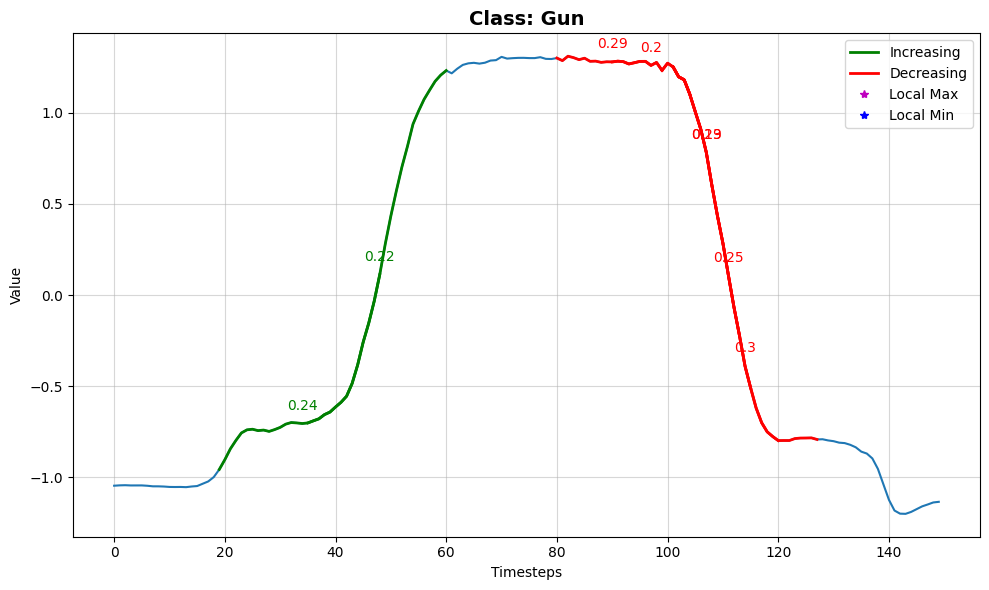

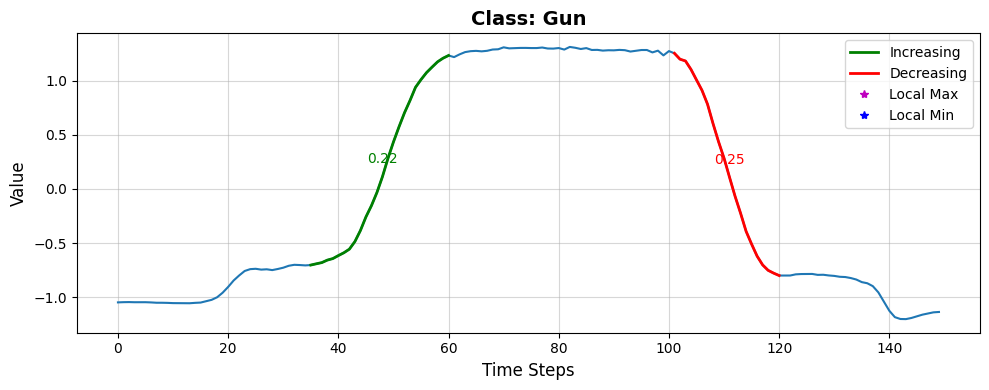

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8295, 0.1705])
Gun:                      0.8295
No Gun:                      0.1705


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.85
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.71
INFO:lomatce.explainer:Model Type: Ridge


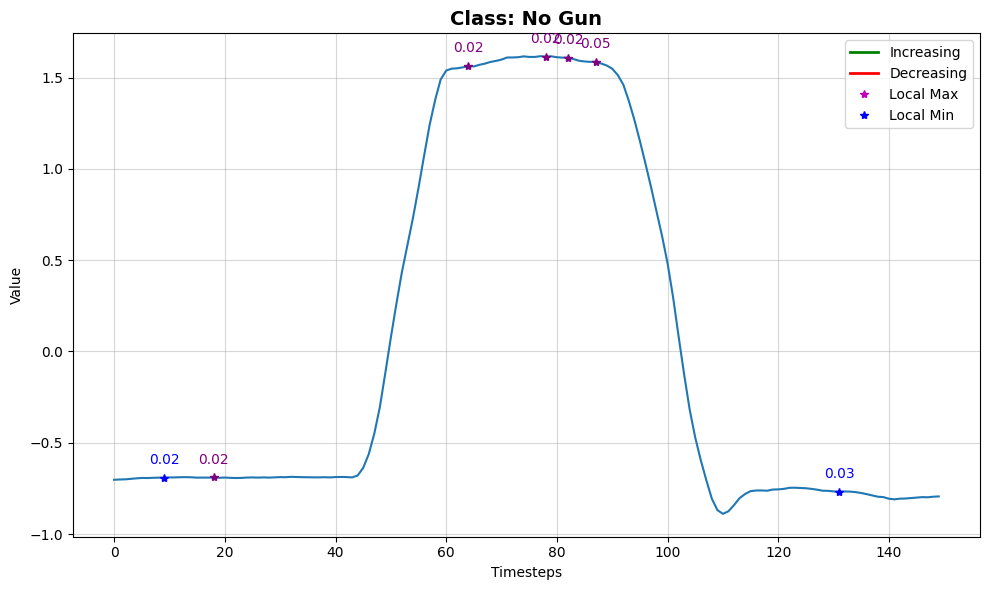

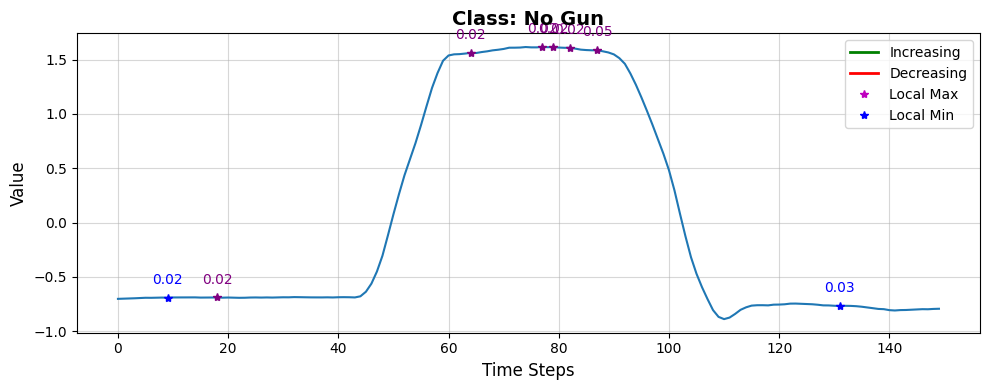

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.2892, 0.7108])
Gun:                      0.2892
No Gun:                      0.7108


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 15 = 15
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 16 = 16


INFO:lomatce.explainer:Final data shape: (1001, 67) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 67


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.67
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.85
INFO:lomatce.explainer:Model Type: Ridge


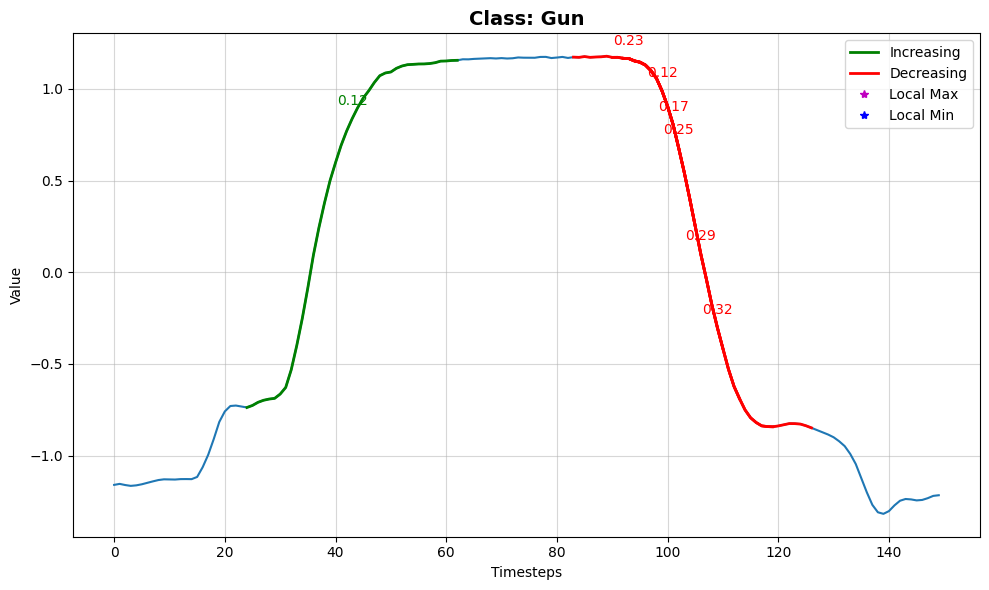

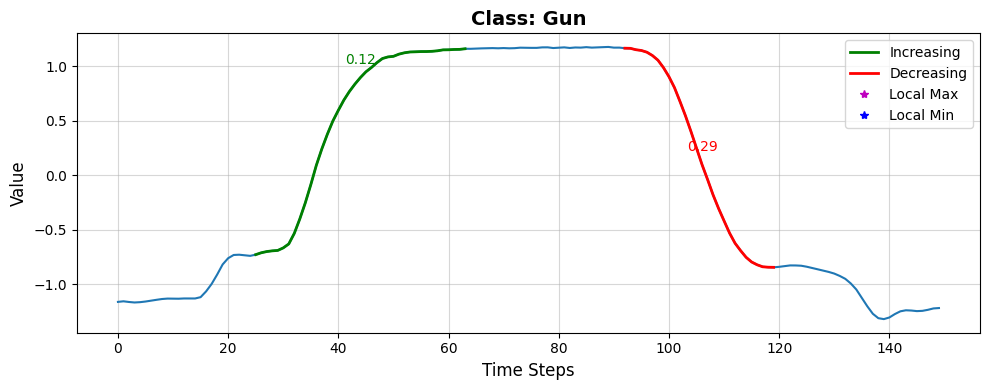

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8603, 0.1397])
Gun:                      0.8603
No Gun:                      0.1397
Replacement methods: total_mean


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 15 = 15
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 72) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 72


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.57
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.75
INFO:lomatce.explainer:Model Type: Ridge


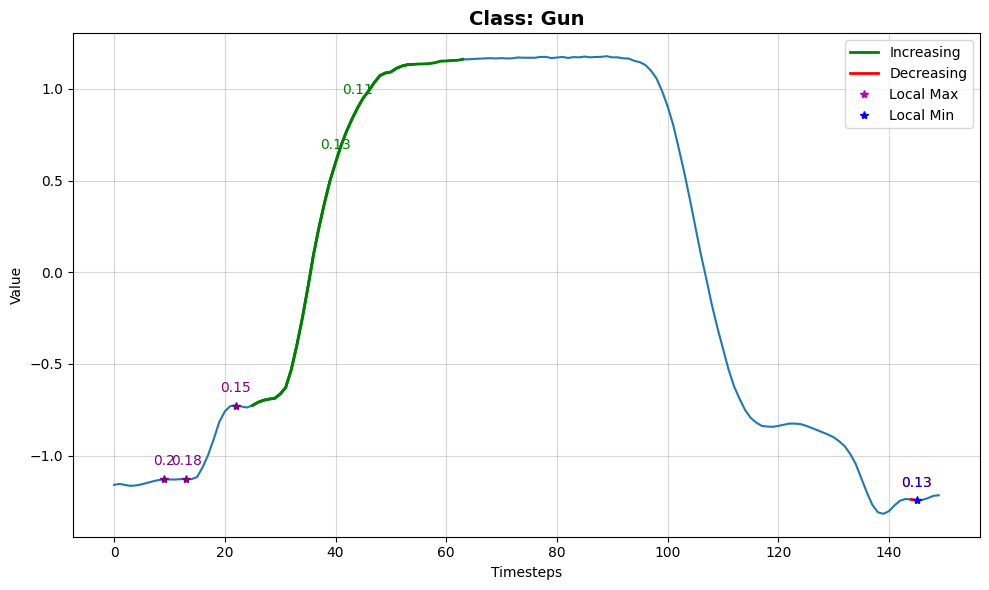

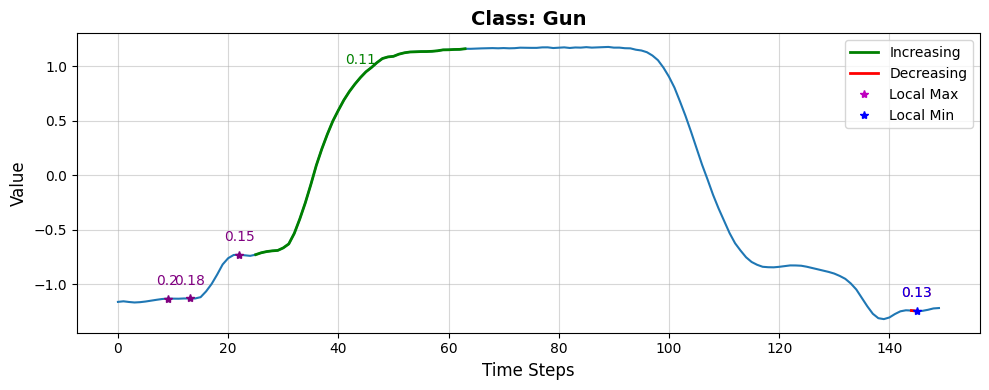

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8603, 0.1397])
Gun:                      0.8603
No Gun:                      0.1397


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 3 = 3


INFO:lomatce.explainer:Final data shape: (1001, 60) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 60


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.77
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.95
INFO:lomatce.explainer:Model Type: Ridge


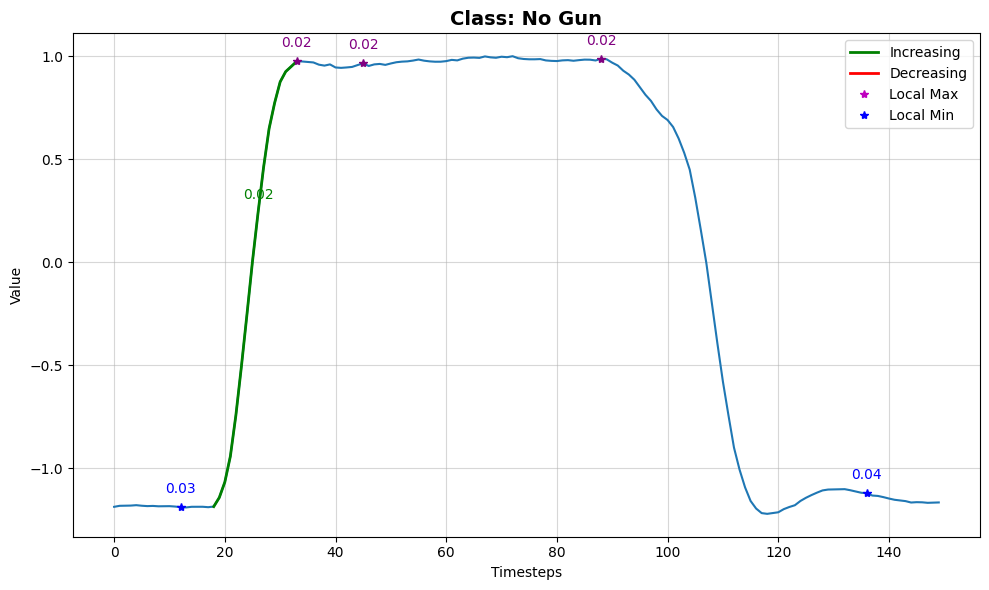

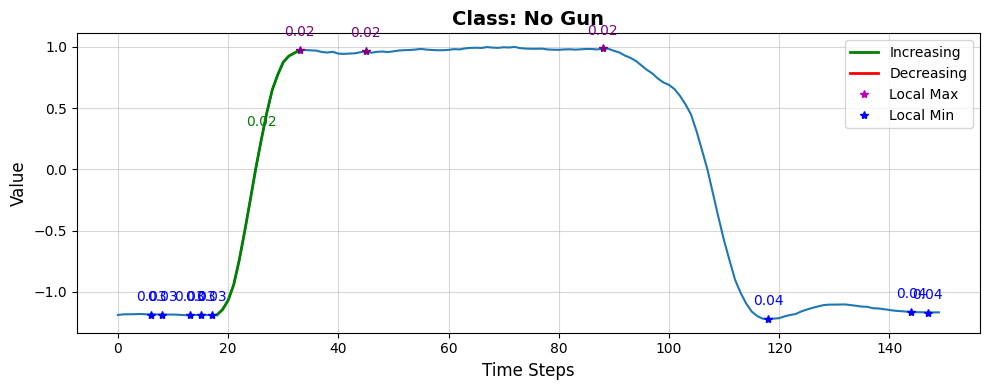

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.0743, 0.9257])
Gun:                      0.0743
No Gun:                      0.9257


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.53
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.74
INFO:lomatce.explainer:Model Type: Ridge


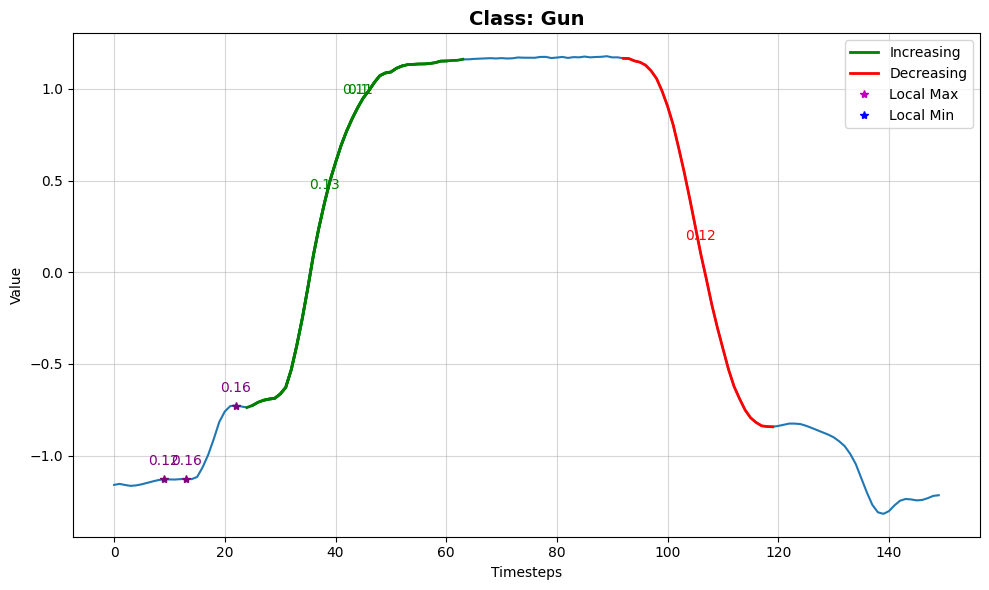

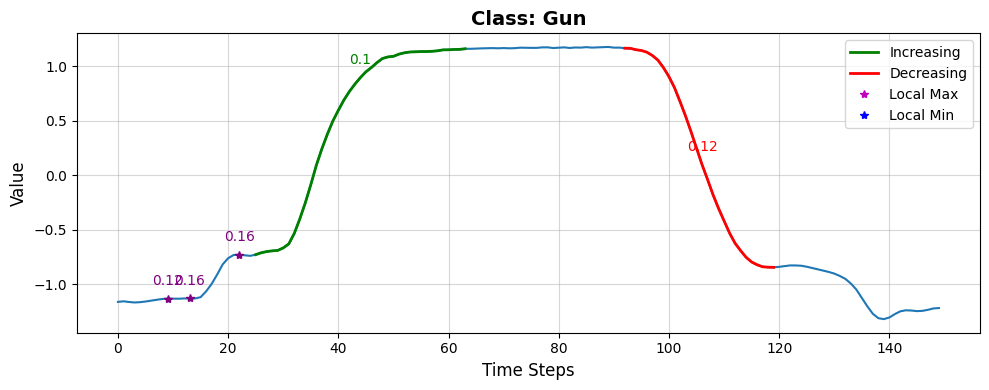

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8603, 0.1397])
Gun:                      0.8603
No Gun:                      0.1397


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 3 = 3
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 3 = 3


INFO:lomatce.explainer:Final data shape: (1001, 44) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 44


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.56
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.66
INFO:lomatce.explainer:Model Type: Ridge


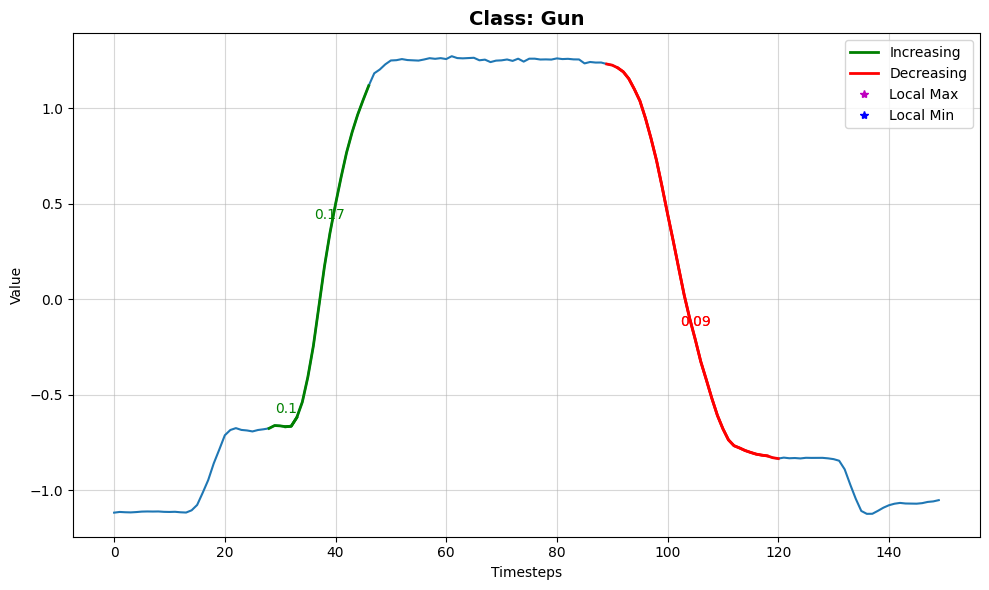

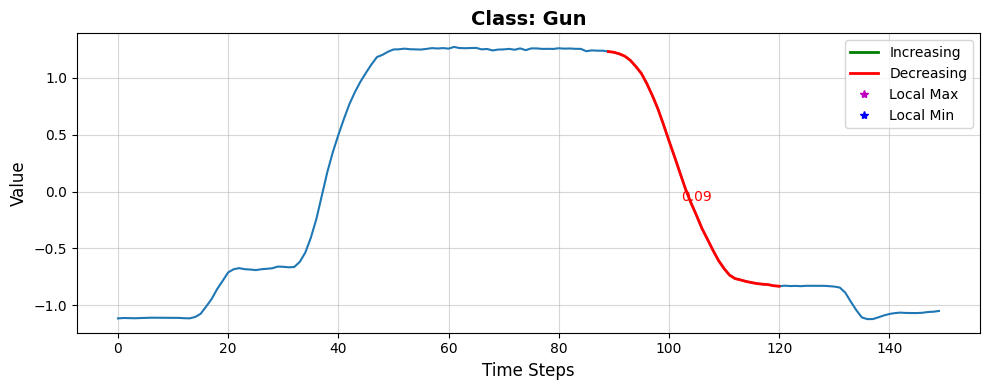

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8529, 0.1471])
Gun:                      0.8529
No Gun:                      0.1471


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 150)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 3 = 3


INFO:lomatce.explainer:Final data shape: (1001, 60) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 60


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.78
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.97
INFO:lomatce.explainer:Model Type: Ridge


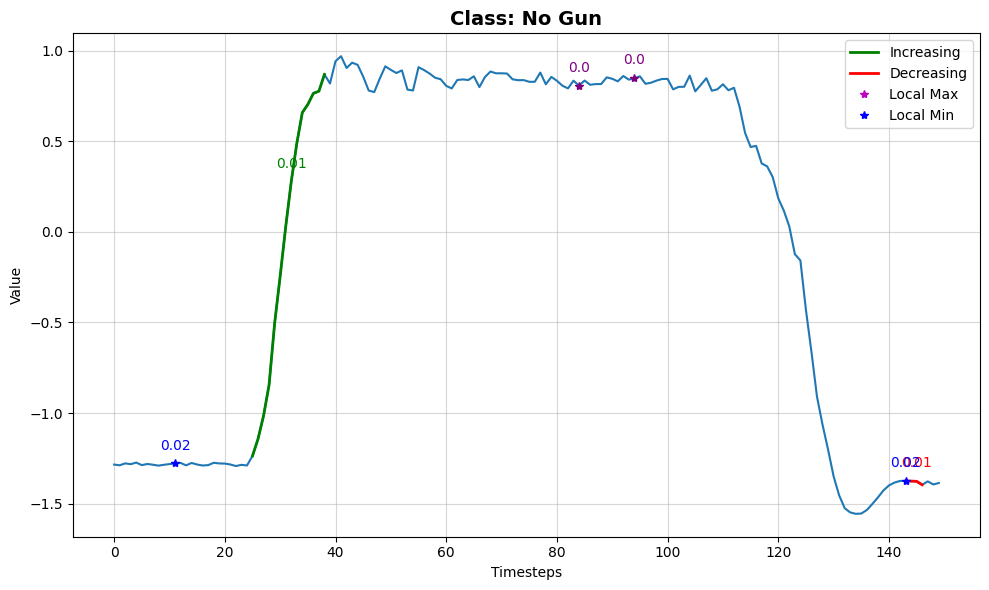

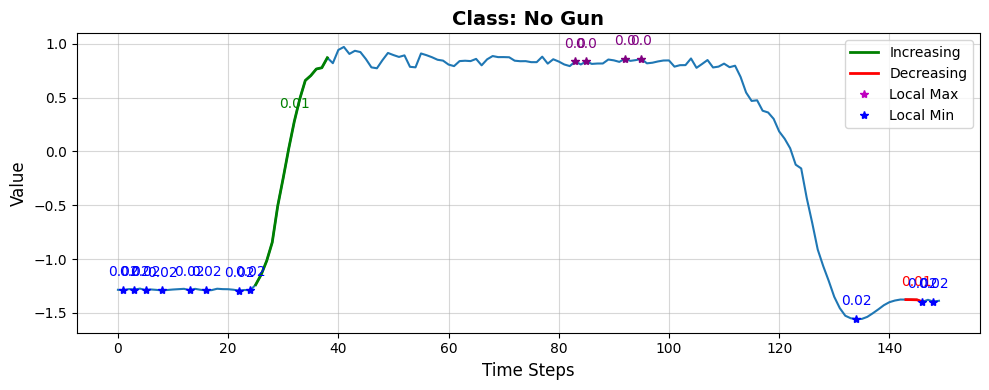

Predection probability : tensor([0.0446, 0.9554])
Gun:                      0.0446
No Gun:                      0.9554


In [18]:
# Define the replacement methods
replacement_methods = ['zero', 'mean', 'total_mean']

# Initialize a dictionary to store the results
results = {}

# Iterate over the replacement methods
for method in replacement_methods:
    # Initialize a list to store prediction scores for the current method
    print(f'Replacement methods: {method}')
    prediction_scores = []
    
    # Run the function 100 times for the current method
    for _ in range(5):
        # Randomly select an instance
        origi_instance_1 = X_test[np.random.randint(len(X_test))]

        # Call the ts_local_explanation function with the current replacement method
        explanation = lomatce_explainer.explain_instance(origi_instance_1, lambda data : predict_fn(data, learn_new), num_perturbations=1000, class_names=class_labels, replacement_method=method)
        
        # Append the prediction score to the list
        # prediction_scores.append(prediction_score)
    
    # Compute the mean and standard deviation of the prediction scores for the current method
#     mean_prediction_score = np.mean(prediction_scores)
#     std_prediction_score = np.std(prediction_scores)
    
#     # Store the results in the dictionary
#     results[method] = (mean_prediction_score, std_prediction_score)

# # Print the results in tabular format
# print("Replacement Method\tAverage Prediction Score\tStandard Deviation")
# for method, (mean_score, std_score) in results.items():
#     print(f"{method}\t\t\t{mean_score:.2f}  \u00B1 {std_score:.2f}")


### Integrated Gradient

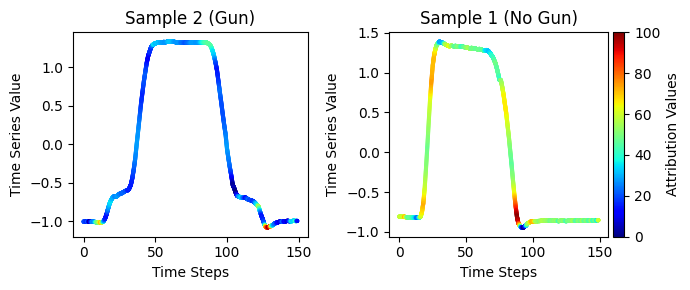

In [15]:
import torch
import numpy as np
from torch import tensor
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a function to compute Integrated Gradients
def compute_integrated_gradients(x, target):
    integrated_gradients = IntegratedGradients(learn_new.model.cpu())
    attr, delta = integrated_gradients.attribute(x, target=target, return_convergence_delta=True)
    return attr.squeeze().cpu().numpy()

# Function to plot Integrated Gradients
def plot_integrated_gradients(x_sample, target, ax):
    # Compute Integrated Gradients for the sample
    attributions = compute_integrated_gradients(x_sample, target)

    max_length = 3000  # Adjust as needed

    time_steps = torch.arange(len(x_sample.reshape(-1,1)))  # Generate time step indices
    minimum = np.min(attributions)

    attributions = attributions - minimum
    attributions = attributions / max(attributions)
    attributions = attributions * 100

    x = np.linspace(0, x_sample.shape[2] - 1, max_length, endpoint=True)

    # Interpolate the time series values
    f_ts = interp1d(range(x_sample.shape[2]), x_sample[0, 0, :])
    y_ts = f_ts(x)

    # Interpolate the attribution values
    f_cas = interp1d(range(len(attributions)), attributions)
    cas_interpolated = f_cas(x).astype(int)

    # Plot the interpolated attribution values against the interpolated time series
    scatter = ax.scatter(x=x, y=y_ts, c=cas_interpolated, cmap='jet', marker='.', vmin=0, vmax=100, linewidths=0.0)
    return scatter

# Select two samples from the test set for visualization
sample_indices = [2, 1]
targets = [0, 1]  # Specify the target for each sample
x_samples = [tensor(X_test[sample_idx][None]) for sample_idx in sample_indices]

# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
labels = class_labels

# Plot Integrated Gradients for each sample
for i, (x_sample, target, ax) in enumerate(zip(x_samples, targets, axs)):
    scatter = plot_integrated_gradients(x_sample, target, ax)
    ax.set_title(f'Sample {sample_indices[i]} ({labels[target]})')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Time Series Value')

# Create a new axis on the right side of the last subplot for the color bar
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Attribution Values')

plt.tight_layout()
plt.show()


### LIME


🔍 Explaining instance 0 — Predicted class: No Gun


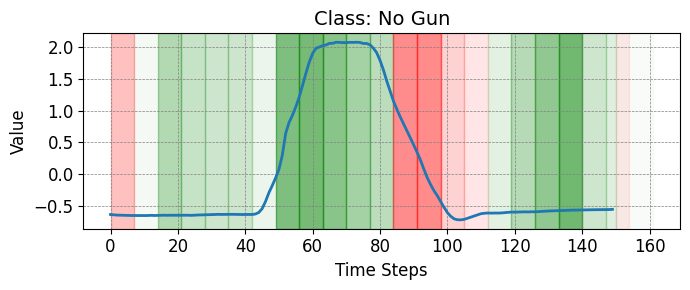


🔍 Explaining instance 1 — Predicted class: No Gun


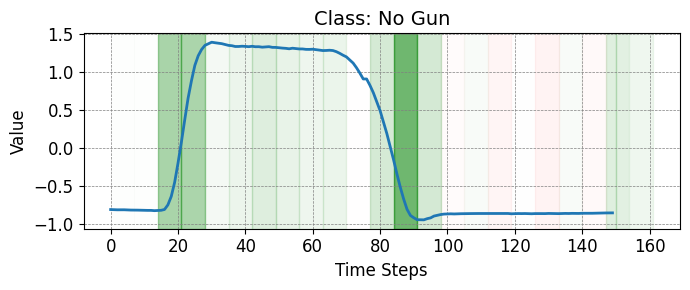


🔍 Explaining instance 2 — Predicted class: Gun


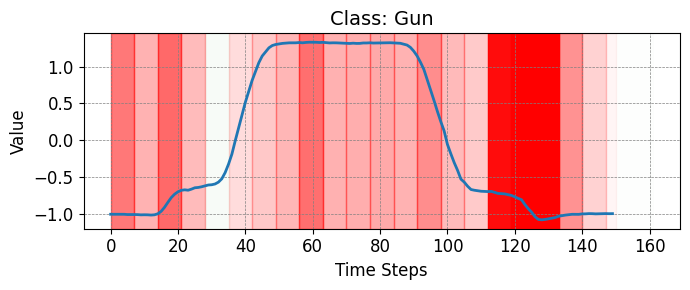


🔍 Explaining instance 3 — Predicted class: No Gun


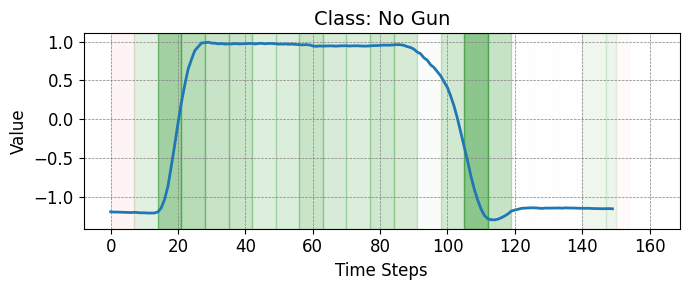


🔍 Explaining instance 4 — Predicted class: Gun


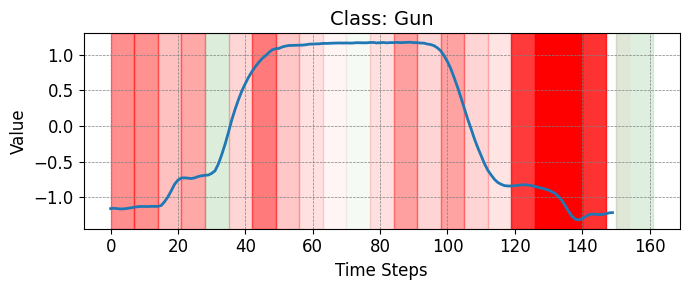

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from lomatce.lime_timeseries import LimeTimeSeriesExplainer
import logging

logging.getLogger().setLevel(logging.WARNING)

# Predict function that LIME will use
def predict_fn(data):
    if len(data.shape) == 2:
        data = data.reshape(data.shape[0], 1, data.shape[1])  # Handle univariate case
    data_dl = test_loader. test_dataloader(learn_new, data)
    data_probas, _, _ = learn_new.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas.numpy()

# Compute LIME and visualize importance
def compute_lime_importances(flat_series, predict_fn, num_slices=25, num_features=10, num_samples=5000, class_label=None, class_names=None):
    if num_slices is None:
        num_slices = len(flat_series)
    explainer = LimeTimeSeriesExplainer(class_names=class_names)

    exp = explainer.explain_instance(
        flat_series,
        predict_fn,
        num_features=num_features,
        num_samples=num_samples,
        num_slices=num_slices,
        replacement_method='total_mean'
    )

    values_per_slice = math.ceil(len(flat_series) / num_slices)
    segments_weights = exp.as_list()
    sorted_segments = sorted(segments_weights, key=lambda x: x[1], reverse=True)

    # Plot
    plt.figure(figsize=(7, 3))
    plt.plot(flat_series, color='C0', linewidth=2)

    for feature, weight in sorted_segments:
        start = feature * values_per_slice
        end = min(start + values_per_slice, len(flat_series))
        color = 'red' if weight < 0 else 'green'
        alpha = min(abs(weight) * 15, 1.0)
        plt.axvspan(start, end, color=color, alpha=alpha, edgecolor='none')

    plt.title(f'Class: {class_label}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

    return sorted_segments

# 🔁 Explain multiple instances
num_instances_to_explain = 5  # Change to 6 or more if desired
for idx in range(num_instances_to_explain):
    label_index = int(test_preds[idx])  # Convert '0' or '1' string to int
    class_label = class_labels[label_index]

    instance = X_test[idx]  # Shape: (channels, time)
    flat_series = instance.flatten() if instance.ndim == 2 else instance  # Flatten if 2D

    print(f"\n🔍 Explaining instance {idx} — Predicted class: {class_label}")
    compute_lime_importances(
        flat_series,
        predict_fn,
        num_slices=24,
        num_features=24,
        num_samples=5000,
        class_label=class_label,
        class_names=class_labels
    )


### SHAP


🔍 Explaining instance 0 — Predicted class: Gun


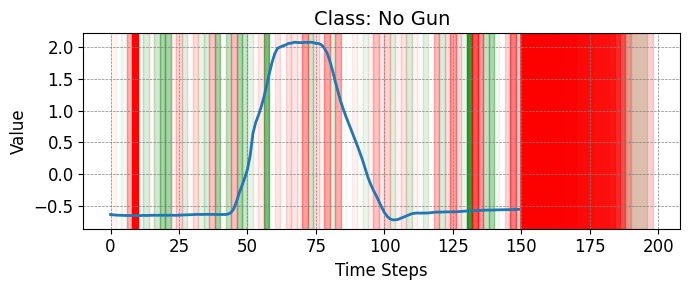


🔍 Explaining instance 1 — Predicted class: Gun


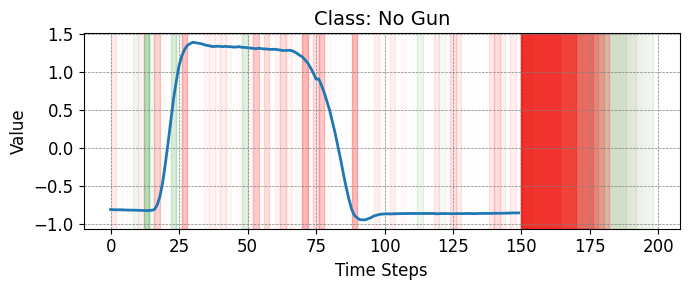


🔍 Explaining instance 2 — Predicted class: Gun


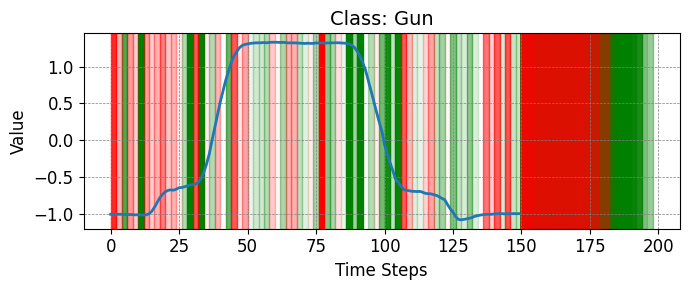

In [23]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 1. Segmenting Function ---
def create_segments(X, num_segments=None):
    num_samples, num_channels, sequence_length = X.shape
    if num_segments is None:
        num_segments = sequence_length
    segment_length = sequence_length // num_segments
    return num_segments, segment_length

# --- 2. Predict Function for SHAP ---
def predict_fn(masks, instance, background_data, num_segments, segment_length, learner):
    masked_inputs = []
    for mask in masks:
        masked_instance = instance.copy()
        for seg_idx in range(num_segments):
            start = seg_idx * segment_length
            end = (seg_idx + 1) * segment_length
            if mask[seg_idx] == 0:
                random_idx = np.random.randint(0, background_data.shape[0])
                background_segment = background_data[random_idx, :, start:end]
                masked_instance[0, :, start:end] = background_segment
        masked_inputs.append(masked_instance[0])
    masked_inputs = np.stack(masked_inputs)  # (num_masks, channels, time)
    data_dl = test_loader.test_dataloader(learner, masked_inputs)
    data_probas, _, _ = learner.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas.numpy()

# --- 3. Plotting SHAP Segment Importance ---
def plot_segment_importance(flat_series, shap_values, segment_length, class_name):
    num_segments = len(shap_values)
    flat_series = flat_series.flatten() if len(flat_series.shape) == 2 else flat_series
    values_per_slice = math.ceil(len(flat_series) / segment_length)
    sorted_segments = sorted(enumerate(shap_values), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(7, 3))
    plt.plot(flat_series, color='C0', linewidth=2)
    
    for segment_idx, weight in sorted_segments:
        start = segment_idx * values_per_slice
        end = min(start + values_per_slice, len(flat_series))
        color = 'red' if weight < 0 else 'green'
        alpha = min(abs(weight) * 15, 1.0)
        plt.axvspan(start, end, color=color, alpha=alpha, edgecolor='none')

    plt.title(f'Class: {class_name}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# --- 4. SHAP Explanation for Multiple Instances ---
# Set number of segments
num_segments, segment_length = create_segments(X_train, num_segments=100)

# Sample background for masking
background_data = X_train[np.random.choice(len(X_train), min(100, len(X_train)), replace=False)]

# Loop over multiple test instances
num_instances_to_explain = 3

for idx in range(num_instances_to_explain):
    instance_to_explain = X_test[idx:idx+1]  # Shape: (1, C, T)
    label_index = int(test_preds[idx])
    class_name = class_labels[label_index]
    print(f"\n🔍 Explaining instance {idx} — Predicted class: {class_label}")
    # SHAP explainer setup
    predict_fn_shap = lambda masks: predict_fn(
        masks,
        instance=instance_to_explain,
        background_data=background_data,
        num_segments=num_segments,
        segment_length=segment_length,
        learner=learn_new
    )

    explainer = shap.Explainer(predict_fn_shap, np.zeros((1, num_segments)))
    shap_values = explainer.shap_values(np.ones((1, num_segments)))
    
    # Extract SHAP values for the predicted class
    if isinstance(shap_values, list):
        shap_value = shap_values[label_index][0]
    else:
        shap_value = shap_values[0, :, label_index]

    shap_values_flat = np.array(shap_value).flatten()
    sorted_indices = np.argsort(-np.abs(shap_values_flat))
    sorted_shap_values = shap_values_flat[sorted_indices]
    important_time_steps = sorted_indices

    # Plot the explanation
    flat_series = instance_to_explain.reshape(1, instance_to_explain.shape[2])
    plot_segment_importance(flat_series, shap_values_flat, num_segments, class_name)
